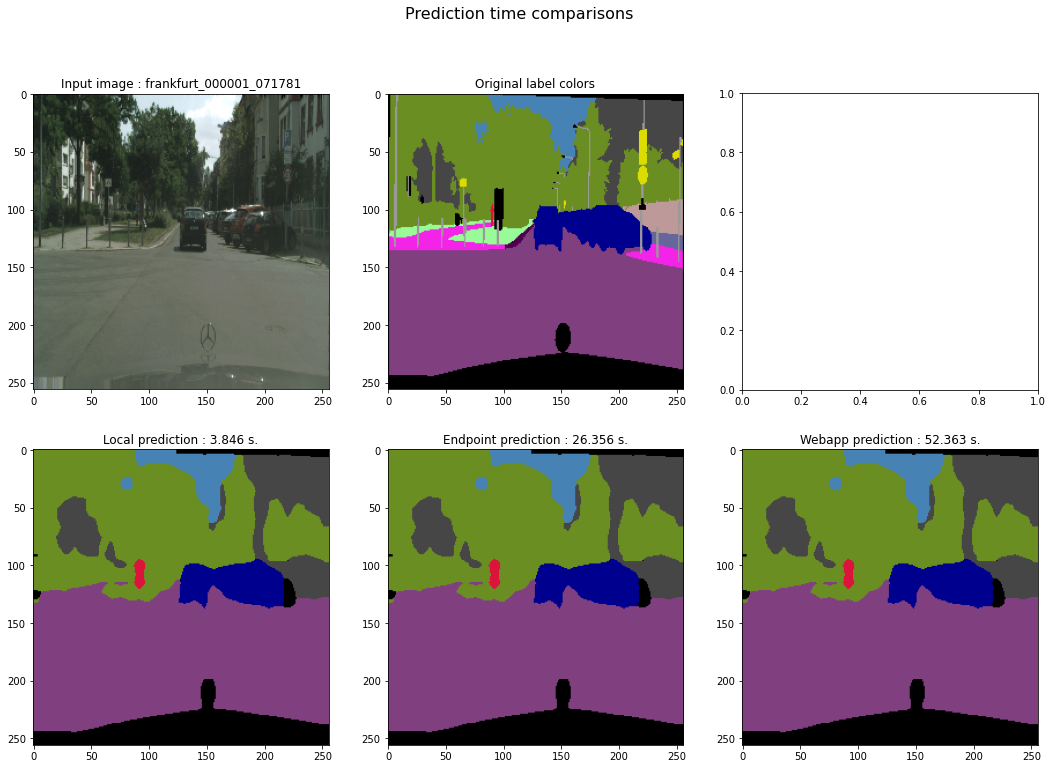

In [3]:
import base64
import json
import os
import time
from io import BytesIO
from pathlib import Path

import numpy as np
import requests
import tensorflow as tf
from dotenv import dotenv_values, load_dotenv
from matplotlib import pyplot as plt
from PIL import Image

import azureml.cityscapes as cityscapes
from azureml.core import Model, Workspace

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


# Get the model
model_name = "deeplab_v3plus_256"
model_input_size = int(model_name.replace("_augment", "").split("_")[-1])
img_size = (model_input_size, model_input_size)


raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    im_binary = base64.b64decode(im_b64)
    im_bytes = BytesIO(im_binary)
    input_img = Image.open(im_bytes).resize(img_size)

    # Local model prediction
    model_path = Path("./../results/downlad/", model_name)
    if not Path(model_path, "model").exists():
        Model(
            Workspace(
                subscription_id=AZURE_SUBSCRIPTION_ID,
                resource_group=AZURE_RESOURCE_GROUP,
                workspace_name=AZURE_WORKSPACE_NAME,
            ),
            model_name,
        ).download(target_dir=model_path)

    model = tf.keras.models.load_model(
        Path(model_path, "model/data/model"),
        custom_objects={
            "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
            "jaccard_loss": cityscapes.jaccard_loss,
        },
    )

    start = time.time()
    output_img = model.predict(np.expand_dims(input_img, 0))

    local_predict_time = time.time() - start
    local_output_mask = cityscapes.cityscapes_category_ids_to_category_colors(
        np.squeeze(
            np.argmax(model.predict(np.expand_dims(input_img, 0)), axis=-1)
        )
    )

    # AzureML registered model Endpoint prediction
    inference_config = dotenv_values(Path(f"../.env.{model_name}"))
    url = inference_config["AZURE_INFERENCE_ENDPOINT"]
    headers = {
        "Content-Type": "application/json",
        "Authorization": ("Bearer " + inference_config["AZURE_INFERENCE_KEY"]),
    }
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))
    r = requests.post(url, headers=headers, data=payload)
    result = r.content

    endpoint_predict_time = r.elapsed.total_seconds()
    endpoint_output_mask = Image.open(BytesIO(base64.b64decode(result)))

    # Flask WebApp prediction
    url = "https://ocp8-webapp.azurewebsites.net/api"
    headers = {
        "Content-Type": "application/json",
    }
    data = {"image_id": image_id}
    r = requests.get(url, headers=headers, params=data)
    predict_time = r.elapsed.total_seconds()
    result = json.loads(r.content)

    webapp_predict_time = r.elapsed.total_seconds()
    webapp_output_mask = Image.open(
        BytesIO(base64.b64decode(result["categories_img_b64_str"]))
    )

    # plot images
    fig, ax = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(18, 12),
    )
    fig.suptitle("Prediction time comparisons", fontsize=16)

    ax[0, 0].title.set_text("Input image : {}".format(image_id))
    val_img = tf.keras.utils.load_img(
        val_input_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 0].imshow(val_img)

    ax[0, 1].title.set_text("Original label colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[0, 1].imshow(val_colors)

    ax[1, 0].title.set_text(
        "Local prediction : {} s.".format(round(local_predict_time, 3))
    )
    ax[1, 0].imshow(local_output_mask)

    ax[1, 1].title.set_text(
        "Endpoint prediction : {} s.".format(round(endpoint_predict_time, 3))
    )
    ax[1, 1].imshow(endpoint_output_mask)

    ax[1, 2].title.set_text(
        "Webapp prediction : {} s.".format(round(webapp_predict_time, 3))
    )
    ax[1, 2].imshow(webapp_output_mask)

    plt.show()
